In [1]:
%%html
<style>
.container { width:80% !important; }
</style>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
np.zeros(10)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [4]:
def dummy(N, label=0):
    signal_len = 8
    if N < 2:
        raise ValueError("hi")
    L = N * 10
    x = 0.1 * np.random.rand(L)
    if not label:
        return x
    pos = np.random.randint(0, L - signal_len)
    x[pos: pos + signal_len] = 1
    return x

def dummy2stream(d, T_max=20):
    """input dim = 10
    """
    T = len(d) / 10
    if T > T_max:
        raise ValueError("T > T_max")
    out = - np.ones((T_max, 10))
    d = np.reshape(d, (T, 10))
    out[:T, :] = d
    return out, T

(110,)


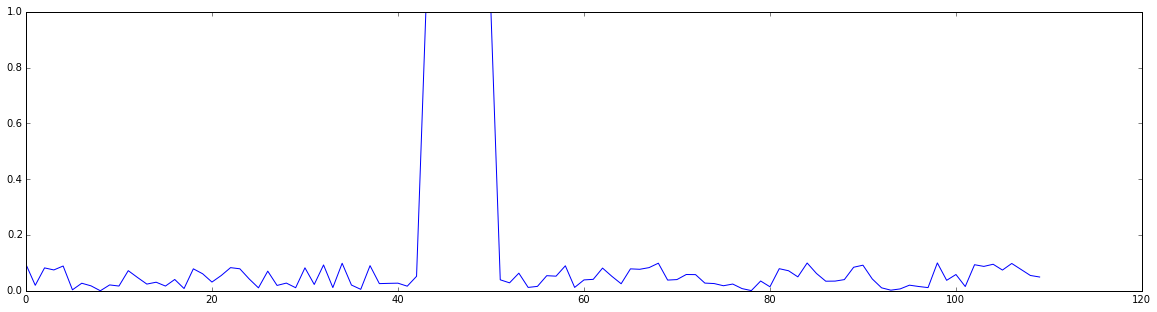

In [5]:
plt.figure(figsize=(20, 5))
D = dummy(11, 1)
plt.plot(D)
print D.shape

In [6]:
d_stream, d_len = dummy2stream(D)
print d_stream.shape
d_len, d_stream[0] == D[: 10]
print d_stream[:, 0]

(20, 10)
[ 0.09487667  0.01704678  0.03132586  0.0823134   0.02735976  1.
  0.03901075  0.04023552  0.01443742  0.09180567  0.05838448 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]


In [7]:
import h5py


In [8]:
d_stream, d_len = dummy2stream(D)
d_len, d_stream[0] == D[: 10]
N, T, V = 100, 20, 10
V_out = 2
for setname, N in [("train", 1000), ("test", 100)]:
    h5 = h5py.File("data/%s.h5" % setname, "w")
    h5.create_dataset("data", shape=(N, T, V), dtype='f8')
    h5.create_dataset("label", shape=(N, V_out), dtype='f8')
    np.random.seed(20)
    for i in range(N):
        l = np.random.rand() > 0.5
        D = dummy(np.random.randint(10, 20), l)
        d_stream, d_len = dummy2stream(D)
        h5["data"][i] = d_stream
        h5["label"][i, :] = (l, 1 - l)
    h5.close()

In [9]:
h5 = h5py.File("data/train.h5", "r")

In [10]:
h5["label"][0]

array([ 1.,  0.])

In [11]:
ind = 2
x = np.reshape(h5["data"][ind, :, :], (200, ))
plt.figure(figsize=(20, 5))
print h5["label"][ind]
plt.plot(x)


In [13]:
h5.close()

# Learning

In [14]:
h5 = h5py.File("data/train.h5", "r")

In [19]:
h5["data"].shape, h5["label"].shape

((1000, 20, 10), (1000, 2))

In [20]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, TimeDistributedDense, Masking
from keras.layers.recurrent import LSTM

In [118]:
in_out_neurons = 10
hidden_neurons = 300
output_shape = 2

model = Sequential()  
#model.add(Masking(mask_value=-1.0, input_shape=(in_out_neurons,)))
model.add(Masking(mask_value=-1.0, input_shape=(20, 10)))
model.add(LSTM(input_dim=in_out_neurons, output_dim=hidden_neurons, return_sequences=False))  
model.add(Dense(output_shape))  
model.add(Activation("sigmoid"))  
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")  

In [119]:
model.fit(h5["data"], h5["label"], batch_size=100, nb_epoch=50, validation_split=0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/50
950/950 [==============================] - 2s - loss: 0.6927 - val_loss: 0.6935
Epoch 2/50
950/950 [==============================] - 2s - loss: 0.6920 - val_loss: 0.6932
Epoch 3/50
950/950 [==============================] - 2s - loss: 0.6912 - val_loss: 0.6933
Epoch 4/50
950/950 [==============================] - 2s - loss: 0.6901 - val_loss: 0.6927
Epoch 5/50
950/950 [==============================] - 2s - loss: 0.6885 - val_loss: 0.6904
Epoch 6/50
950/950 [==============================] - 2s - loss: 0.6834 - val_loss: 0.6785
Epoch 7/50
950/950 [==============================] - 2s - loss: 0.6741 - val_loss: 0.6786
Epoch 8/50
950/950 [==============================] - 2s - loss: 0.6633 - val_loss: 0.6595
Epoch 9/50
950/950 [==============================] - 2s - loss: 0.6604 - val_loss: 0.6587
Epoch 10/50
950/950 [==============================] - 2s - loss: 0.6595 - val_loss: 0.6596
Epoch 11/50
950/950 [=======================

In [104]:
h5_test = h5py.File("data/test.h5", "r")

In [105]:
h5_test["data"].shape

(100, 20, 10)

In [106]:
predicted = model.predict(np.array(h5["data"]))

In [107]:
predicted.shape

(1000, 2)

[ 1.  0.] [  9.95925367e-01   1.60970812e-05]


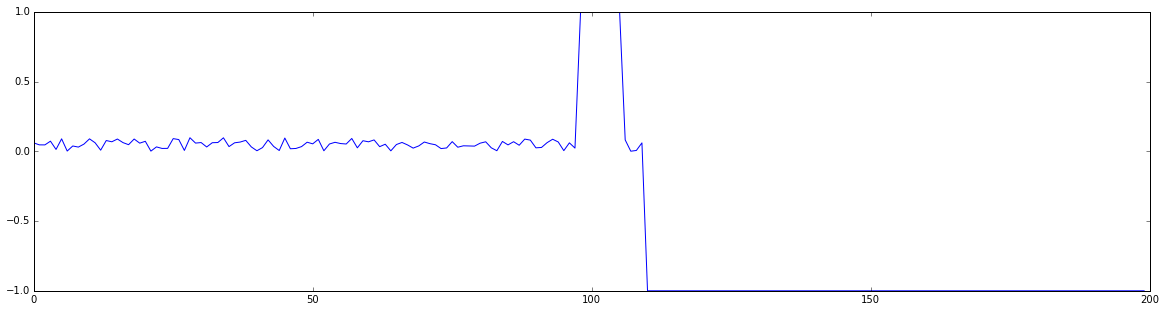

In [108]:
ind = 111
x = np.reshape(h5["data"][ind, :, :], (200, ))
plt.figure(figsize=(20, 5))
print h5["label"][ind], predicted[ind]
plt.plot(x)

In [117]:
h5["data"][ind][10, :]

array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         8.16201448e-02,   6.44534997e-04,   6.01790842e-03,
         6.03894372e-02])